In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [102]:
df = pd.read_csv('/content/loan_data_100rows.csv')

In [103]:
df.shape

(100, 3)

In [104]:
df.head()

,income,credit_score,loan_approved
0,25795,715,1
1,10860,792,0
2,48158,598,0
3,21284,671,0
4,16265,713,0


<Axes: xlabel='income', ylabel='credit_score'>

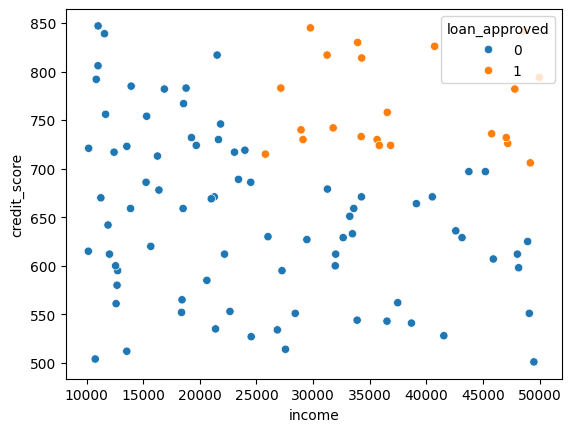

In [105]:
sns.scatterplot(data=df, x='income', y='credit_score', hue='loan_approved')

In [106]:
# Isolating the features and labels
X = df.iloc[:,0:2]
y = df.iloc[:,-1]

In [107]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [108]:
# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [109]:
# Adding bias term for manual implementation
X_train_manual = np.hstack((np.ones((X_train_scaled.shape[0], 1)), X_train_scaled))
X_test_manual = np.hstack((np.ones((X_test_scaled.shape[0], 1)), X_test_scaled))

## Implementing Perceptron manually

In [110]:
# Manual Perceptron Implementation
weights = np.zeros(X_train_manual.shape[1])
learning_rate = 0.01
epochs = 50

def step(x):
    return 1 if x >= 0 else 0

# Training
for epoch in range(epochs):
    errors = 0
    for xi, target in zip(X_train_manual, y_train):
        output = step(np.dot(xi, weights))
        update = learning_rate * (target - output)
        weights += update * xi
        errors += int(update != 0)
    if errors == 0:
        break

print("\nFinal weights:", weights)


Final weights: [-0.05        0.03279325  0.03542822]


In [111]:
# Prediction
def predict(X_scaled):
    return np.array([step(np.dot(xi, weights)) for xi in X_scaled])

y_pred_manual = predict(X_test_manual)
accuracy_manual = np.mean(y_pred_manual == y_test)
print("Manual Perceptron Test Accuracy:", accuracy_manual)

Manual Perceptron Test Accuracy: 0.95


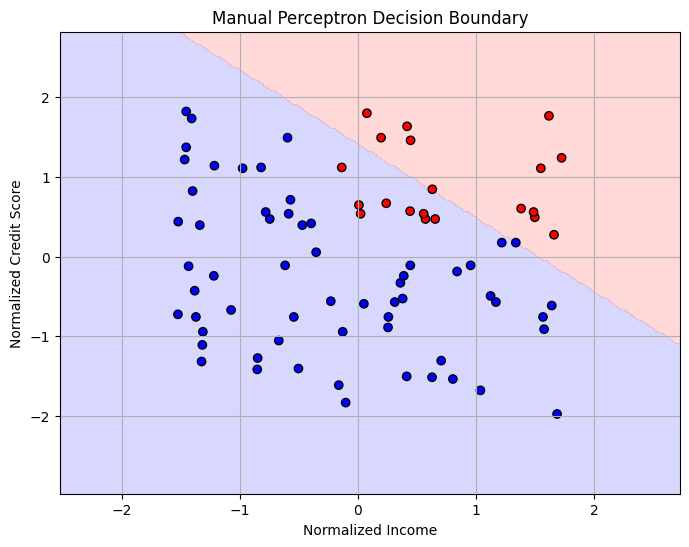

In [112]:
# Manual Perceptron Decision Boundary
x_min, x_max = X_train_manual[:, 1].min() - 1, X_train_manual[:, 1].max() + 1
y_min, y_max = X_train_manual[:, 2].min() - 1, X_train_manual[:, 2].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

grid_manual = np.c_[np.ones(xx.ravel().shape[0]), xx.ravel(), yy.ravel()]
Z_manual = np.array([step(np.dot(x, weights)) for x in grid_manual])
Z_manual = Z_manual.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z_manual, levels=[-0.5, 0.5, 1.5], alpha=0.3, cmap='bwr')
plt.scatter(X_train_manual[:, 1], X_train_manual[:, 2], c=y_train, cmap='bwr', edgecolors='k')
plt.xlabel("Normalized Income")
plt.ylabel("Normalized Credit Score")
plt.title("Manual Perceptron Decision Boundary")
plt.grid(True)
plt.show()

## Using Perceptron() from sklearn.linear_model

In [113]:
from sklearn.linear_model import Perceptron

In [114]:
p = Perceptron(max_iter=1000, eta0=0.01, random_state=42)
p.fit(X_train_scaled, y_train)

Perceptron(eta0=0.01, random_state=42)

In [115]:
accuracy_sklearn = p.score(X_test_scaled, y_test)
print("Sklearn Perceptron Test Accuracy:", accuracy_sklearn)

Sklearn Perceptron Test Accuracy: 0.95


In [116]:
p.coef_

array([[0.02438509, 0.05011483]])

In [117]:
p.intercept_

array([-0.03])

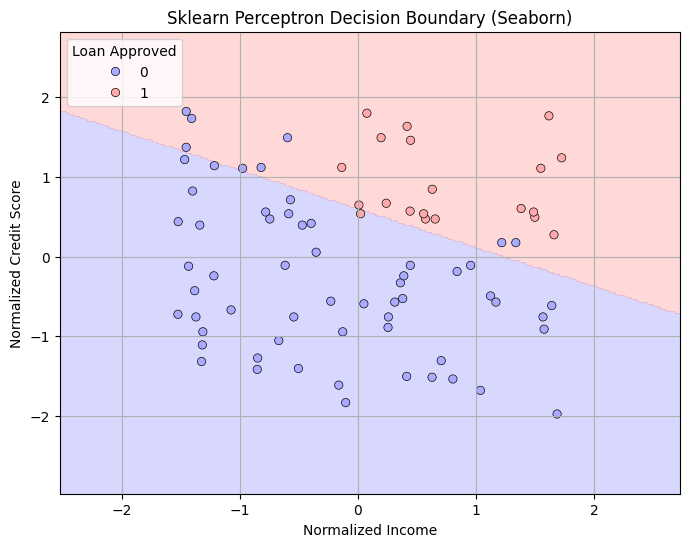

In [118]:
# Decision boundary for sklearn model
x_min, x_max = X_train_scaled[:, 0].min() - 1, X_train_scaled[:, 0].max() + 1
y_min, y_max = X_train_scaled[:, 1].min() - 1, X_train_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

grid = np.c_[xx.ravel(), yy.ravel()]
Z = p.predict(grid)
Z = Z.reshape(xx.shape)

train_df = pd.DataFrame({
    "Normalized Income": X_train_scaled[:, 0],
    "Normalized Credit Score": X_train_scaled[:, 1],
    "Loan Approved": y_train
})

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, levels=[-0.5, 0.5, 1.5], alpha=0.3, cmap='bwr')
sns.scatterplot(data=train_df, x="Normalized Income", y="Normalized Credit Score",
                hue="Loan Approved", palette='bwr', edgecolor='k')
plt.legend(title="Loan Approved", loc='upper left')
plt.title("Sklearn Perceptron Decision Boundary (Seaborn)")
plt.grid(True)
plt.show()

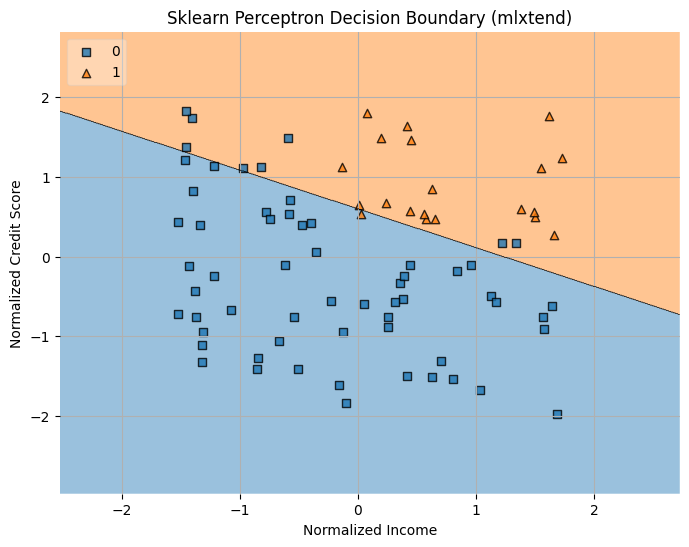

In [119]:
# Mlxtend Plot
X_plot = X_train_scaled  # no bias column
plt.figure(figsize=(8, 6))
plot_decision_regions(X_plot, y_train.to_numpy(), clf=p, legend=2)
plt.xlabel("Normalized Income")
plt.ylabel("Normalized Credit Score")
plt.title("Sklearn Perceptron Decision Boundary (mlxtend)")
plt.grid(True)
plt.show()

## 🧠 Why the Manual and Sklearn Perceptron Outputs Differ

Although both the **manual Perceptron implementation** and `sklearn.linear_model.Perceptron` are based on the same learning algorithm, their outputs (especially the decision boundary) may **vary slightly** due to the following key reasons:



### 🔹 1. Bias Handling

* **Manual Perceptron**: Requires explicitly adding a bias term by appending a column of ones to the input features.
* **Sklearn Perceptron**: Automatically handles bias using an internal intercept (`fit_intercept=True` by default).

**Mismatch in bias handling** can shift the decision boundary unless configured consistently.


### 🔹 2. Data Shuffling

* **Manual Implementation**: Processes training samples in the original order (no shuffling).
* **Sklearn**: Shuffles training data before each epoch (`shuffle=True` by default), which affects weight updates and convergence path.


### 🔹 3. Learning Rule & Update Criteria

* **Manual**: Uses a simple binary step function and updates weights only on misclassification.
* **Sklearn**: Uses a more robust update rule with margin considerations and may optimize using additional heuristics under the hood.


### 🔹 4. Initialization and Convergence

* **Both** can start from zero weights, but even small variations in:

  * Learning rate (`eta0`)
  * Epoch count (`max_iter`)
  * Stopping conditions
    can lead to slightly different final weight vectors.


### 🔹 5. Internal Optimizations in Scikit-learn

* Sklearn's implementation is highly optimized and may include numerical stability improvements or early stopping strategies not present in a basic manual implementation.